<div style="text-align: center;font-size:30px"> $\color{steelblue}{\underline{\text{Minería de Datos}}}$ 
<div style="text-align: center;font-size:23px"> $\color{steelblue}{\underline{\text{Tarea 2 - Solución}}}$ 

<div style="text-align: left;font-size:14px"> By Nibaldo Pino Araya. </div>
<div style="text-align: left;font-size:14px"> <a href = "mailto: n.pino@uc.cl">n.pino@uc.cl</a> </div>
</div>

## $\underline{\text{Requerimientos}}$

Abordar el problema de propensión a morosidad, es decir, construir un modelo que estime la probabilidad que un cliente no pague su crédito.


## $\underline{\text{Descripción del Dataset}}$

- `SeriousDlqin2yrs`: Variable a predecir, es un flag que indica si es que la persona tiene más de 90 días de morosidad en los últimos dos años.
- `RevolvingUtilizationOfUnsecuredLines`: Porcentaje de saldo utilizado en línea de crédito, esto es el cupo utilizado en tarjetas y línea dividido por el cupo total en ambas.
- `NumberOfTime30-59DaysPastDueNotWorse`: Número de veces que el cliente ha estado con más de 30 días vencida la deuda pero menos de 60 días en los últimos 2 años.
- `DebtRatio`: Razón entre gastos, pago de deudas y costo de vida con el ingreso bruto.
- `MonthlyIncome`: Ingreso mensual.
- `NumberOfOpenCreditLinesAndLoans`: Número de creditos vigentes y tarjetas.
- `NumberOfTimes90DaysLate`: Número de veces en que el cliente pagó después de 90 días.
- `NumberRealEstateLoansOrLines`: Número de créditos hipotecarios.
- `NumberOfTime60-89DaysPastDueNotWorse`: Cantidad de veces que el cliente ha estado atrasado entre 60 y 89 días en los últimos dos años.
- `NumberOfDependents`: Número de integrantes en el grupo familiar, excluyéndose a ellos mismos.

## $\underline{\text{Preliminares}}$

In [1]:
# Tratamiento de DataFrames
import numpy as np
import pandas as pd

# librerias para graficar
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
plt.style.use('seaborn-white')
#plt.style.use('ggplot')

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

import pickle

# Matriz de Missing Data
import missingno as msngo

# Control de Warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# Embellecimiento de Textos
from IPython.display import display, Markdown

# Info Sistema
import os

import funciones_ancilares as func

# Opciones Generales
pd.set_option("display.max_rows", 112)
pd.set_option("display.max_info_columns", 112)
pd.set_option("display.max_colwidth", 3000)

## $\underline{\text{Ingesta y Split de Datos}}$

In [2]:
data = pd.read_csv('loan.csv').drop(columns = 'Unnamed: 0')

# Genera data de train y test
data_train, data_test = train_test_split(data, test_size=.3, stratify = data.iloc[:,0], random_state = 0)
print('data_train: ', data_train.shape)
print('data_test: ', data_test.shape)

# Exporta data de train y test
data_train.to_csv ('data_train.csv', index = False)
data_test.to_csv ('data_test.csv', index = False)

data_train:  (105000, 11)
data_test:  (45000, 11)


## $\underline{\text{Construcción de la Clase}}$

In [3]:
class model:
    """
    This class:
        -Read training data.
        -Processes missing data.
        -Displays densities for each variable in the ingested data.
        -Transforms variables, indicated by the user, for the ingested data.
        -Calculate and graph variable selection metrics.
        -Fit models and generate your prediction.
        -Generate report with metrics of the adjusted models.
        -Save the generated class as a reproducible model.
    """
    
    def __init__(self, ruta, max_na=.05):
        self.raw_data = pd.read_csv(ruta)
        self.max_na = max_na
        self.X_train = self.treatment_missings(self.raw_data.iloc[:, 1:])
        self.y_train = self.raw_data.iloc[:, 0]
        self.X_test = None
        self.y_test = None
        self.y_pred = None
        self.model = None
        self.metrics = None
        self.log_trans = None
        self.cat_trans = None
        self.max_bins = None
        self.path = os.path.join(os.getcwd(), 'Analisis')
        self.mkdir_p(self.path)
        self.density(self.X_train)
        
        
    def treatment_missings(self, data):
        """
        Treatment of missings data.
        """
        for col in data.columns:
            na_count = data[col].isnull().sum()
            percent_na = (na_count/data.shape[0])
            if percent_na <= self.max_na:
                if data[col].dtype == 'object':
                    data[col].fillna(stats.mode(data[col])[0][0], inplace = True)
                else:
                    data[col].fillna(np.nanmedian(data[col]), inplace = True)
            else:
                data.loc[:, col] = (data[col].isnull()) * 1 
                #var = col +'_Missings'
                #data[var]=np.where(data[col].isnull(),'Missing','Not_Missing')
        return data
    
    
    def target_count(self):
        """
        Countplot for target.
        """   
        sns.countplot(self.y_train, palette=["#0101DF", "#DF0101"]).set_title('Distribution Class for Target');
        
        
    def subsampling(self):
        """
        Sub sample for imbalance data.
        """
        data = self.X_train.copy() 
        data[self.y_train.name] = self.y_train
        
        data = data.sample(frac=1)
        
        target_1 = data.loc[data[self.y_train.name] == 1]
        target_0 = data.loc[data[self.y_train.name] == 0][:len(target_1)]

        sub_sample = pd.concat([target_1,target_0])
        sub_sample = sub_sample.sample(frac=1, random_state = 0)
        
        self.X_train = sub_sample.drop(columns=[self.y_train.name])
        self.y_train = sub_sample[self.y_train.name]
        
        print('Sub Sampling Done OK.')
        self.target_count()

        
    def pcorr_data(self):
        """
        Plot Heatmap for Pearson Correlation.
        """
        data = self.X_train.copy() 
        data[self.y_train.name] = self.y_train
        
        colormap = plt.cm.RdBu
        plt.figure(figsize=(10,10))
        plt.title('Pearson Correlation of Features', y=1.05, size=15)
        sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
                    square=True, cmap=colormap, linecolor='white', annot=True);
        
        
    def features_class(self):
        """
        Boxplot for each variable, with respect target.
        """
        data = self.X_train.copy() 
        data[self.y_train.name] = self.y_train

        # Boxplot 
        fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
        fig.text(0.5,0.92,"Boxplot Features vs Target", fontsize=16, horizontalalignment='center')
        fig.subplots_adjust(hspace=0.4)
        for i, column in enumerate(self.X_train.columns):
            sns.boxplot(x=self.y_train.name, y=column, data=data, palette=["#0101DF", "#DF0101"], ax=axes[i//2,i%2])
            axes[i//2,i%2].set_title(column + ' vs ' + self.y_train.name)
            
        
        
    def detection_outlier(self, df_features, df_target, cols):
        """
        Detection Outliers for data.
        """
        data = df_features.copy() 
        data[df_target.name] = df_target
        
        outlier_indices = np.array([])

        for col in cols:
            Q1 = np.percentile(data[col],25)
            Q3 = np.percentile(data[col],75)
            IQR = Q3 - Q1
            outlier_step = 1.5 * IQR
            outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step )].index
            outlier_indices = np.append(outlier_indices,outlier_list_col.values)   

        index_outlier = np.unique(outlier_indices)

        df_features = data.drop(index_outlier, axis = 0).reset_index(drop=True)
        df_target = data[df_target.name]
        
        
        
    def mkdir_p(self, mypath):
        """
        Creates a directory. Equivalent to using mkdir -p on the command line.
        """
        from errno import EEXIST
        from os import makedirs,path
        
        try:
            makedirs(mypath)
        except OSError as exc:
            if exc.errno == EEXIST and path.isdir(mypath):
                pass
            else: raise
    
            
    def density(self, df):
        """
        Create density plot and bloxplot of data
        """
        # Construccion del resumen
        estatistics = pd.concat([df.describe().T, pd.Series(df.skew(), name = 'skew')], axis=1)
        estatistics.to_csv(self.path + '\Describe_Data.csv', index = True)
        display(estatistics)

        #Displot
        fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
        fig.text(0.5,0.92,"Gráfico de Distribuciones por variable", fontsize=16, horizontalalignment='center')
        for i, column in enumerate(df.columns):
            sns.distplot(df[column], hist=True, rug=False, kde_kws={'bw':1},ax=axes[i//3,i%3])
            axes[i//3,i%3].axvline(df[column].mean(), color='tomato', linestyle='--', label='mean')
            axes[i//3,i%3].axvline(df[column].median(), color='tomato', linestyle='-', label='median')
            axes[i//3,i%3].legend()
            
        name_chart = self.path + '\Displot' + '.png'
        fig.savefig(name_chart)
        
        #Graficos de distribución Boxplot
        fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(13, 12))
        fig.text(0.5,0.92,"Boxplot por variable", fontsize=16, horizontalalignment='center')
        for i, column in enumerate(df.columns):
            sns.boxplot(df[column],ax=axes[i//3,i%3])

        name_chart = self.path + '\Boxplot' + '.png'
        fig.savefig(name_chart)
        
        
    def transform_data(self, df, log_trans = [], cat_trans = [], max_bins = 2, density = False):
        """
        Transform data for indicated variables
        """
        self.log_trans = log_trans
        self.cat_trans = cat_trans
        self.max_bins = max_bins
            
        if len(log_trans) > 0:
            for i in log_trans:
                df[i] = np.log(df[i] + 1)
                    
        if len(cat_trans) > 0:
            for i in cat_trans:
                df[i] = pd.qcut(df[i].rank(method='first'), q=max_bins, labels=range(max_bins)).astype(int)
            
        if density == True:
            self.density(df)
        
        
    def feature_importances(self):
        """
        Calculates variable selection metrics:
        IV: Information Value
        IG: Information Gain
        """
        # Calculate Information Value
        df = self.X_train
        target = self.y_train
        max_bin = 20
        
        final_iv, iv = func.data_vars(df,target)
        iv2 = iv.sort_values(by = ['IV'], ascending = False).rename(columns={"VAR_NAME": "Variables", "IV": "Information Value"}).set_index('Variables')
        
        #Calculate Information Gain
        ig = {}
        features = self.X_train.columns
        train = self.X_train.copy() 
        train[self.y_train.name] = self.y_train
        
        for i in features:
            ig.update({i:func.information_gain(train, self.y_train.name, i, split_criterion = 'entropy', n = max_bin)})
        information_gain = pd.DataFrame(ig, index = features)
        inf_gain  = pd.DataFrame(information_gain.iloc[0,:].rename("Information Gain")).sort_values(by = ['Information Gain'], ascending = False)
        
        #Features Importance Plot from 
        from sklearn import ensemble
        model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1)
        model.fit(self.X_train, self.y_train)

        ## plotando as importâncias ##
        feat_names = train.columns.values
        importances = model.feature_importances_
        std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
        indices = np.argsort(importances)[::-1][:20]

        plt.figure(figsize=(6,6))
        plt.title("Feature importances")
        plt.bar(range(len(indices)), importances[indices], color="tomato", yerr=std[indices], align="center")
        plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
        plt.xlim([-1, len(indices)])

        #Make report
        metrics = iv2.merge(inf_gain, left_index=True, right_index=True)
        display(metrics)
        
        display(iv2.plot(title='Metrics Features Selection: Information Value', kind='barh', color = 'darkorange'))
        display(inf_gain.plot(title='Metrics Features Selection: Information Gain', kind='barh', color = 'forestgreen'))
        plt.show();


    def model_fit(self, max_depth = None):
        """
        Fit Models LogisticRegression and DecisionTreeClassifier
        """
        self.modelo = {}
        
        #Fit Logistic Regression
        lr = LogisticRegression(random_state = 16626)
        lr.fit(self.X_train, self.y_train)
        
        #Fit Decision Tree Classifier
        clf = DecisionTreeClassifier(criterion = 'gini', max_depth = max_depth, random_state = 16626)
        clf.fit(self.X_train, self.y_train)

        self.modelo = {lr.__class__.__name__: lr, clf.__class__.__name__: clf}     
        

        
    def predict(self, ruta):
        """
        Model predict for test data.
        Previously, the data read treatment is carried out.
        """
        df = pd.read_csv(ruta)
        self.X_test = self.treatment_missings(df.iloc[:, 1:])
        self.y_test = df.iloc[:, 0]
        self.y_pred = {}
        
        if ((self.log_trans != None) or (self.cat_trans != None)):
            self.transform_data(self.X_test, 
                                log_trans = self.log_trans, 
                                cat_trans = self.cat_trans, 
                                max_bins = self.max_bins, 
                                density = False)
        else:
            pass

        for key in self.modelo:
            self.y_pred.update({key: self.modelo[key].predict(self.X_test)}) 
        
        
    def clasification_report(self):
        """
        Generate metric report for fitted models
        """
        self.metrics = {}
        metrics = {}
        CM = {}
        auc = {}
        
        for key in self.modelo:
            CM.update({key: confusion_matrix(self.y_test, self.y_pred[key])})

            print("Classification Report Model {}".format(key))
            metric = pd.DataFrame(classification_report(self.y_test, self.y_pred[key], output_dict=True))
            self.metrics.update({key:metric})
            display(metric)

            print("Confusion Matrix Model {}".format(key))
            conf = func.confusion_to_df(CM[key])
            display(conf)
                      
            fpr, tpr, thresholds = roc_curve(self.y_test, self.modelo[key].predict_proba(self.X_test)[:,1])
            plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='tomato')
            plt.plot(fpr, tpr, marker='.', lw=2)
            plt.title("ROC curve model {}".format(key))
            plt.xlabel('false positive rate')
            plt.ylabel('true positive rate')
            plt.show();
            
            print("AUC Model {}".format(key))
            auc_model = roc_auc_score(self.y_test, self.modelo[key].predict_proba(self.X_test)[:,1])
            auc.update({key:auc_model})
            display(auc_model)
            display(Markdown("----"))
            
            metrics.update({'Model_'+ key: [auc_model,
                                       accuracy_score(self.y_test, self.y_pred[key]).round(5), 
                                       metric.iloc[0]['weighted avg'].round(5),
                                       metric.iloc[1]['weighted avg'].round(5),
                                       metric.iloc[2]['weighted avg'].round(5)]})
        
        print("Metrics Comparation")
        errors_df = pd.DataFrame(metrics, index=['AUC', 'Accuracy', 'Presicion', 'Recall', 'F1'])
        display(errors_df.head())
        display(errors_df.plot(title='Models Metrics for Class Models', kind='barh',figsize=(8, 6)).legend(bbox_to_anchor=(1.0, 0.5)));
        
        
    def save_class(self):
        """
        Data persistence: Saving a Class Object .
        """
        ruta = f'./{self.y_train.name}.pkl'
        with open(ruta, 'wb') as output:
            pickle.dump(self, output, pickle.HIGHEST_PROTOCOL)
        print("Save Class in: {}".format(ruta))

# Pruebas

,count,mean,std,min,25%,50%,75%,max,skew
RevolvingUtilizationOfUnsecuredLines,105000.0,5.819674,257.063237,0.0,0.029666,0.153984,0.556816,50708.0,109.463550
age,105000.0,52.257333,14.757197,0.0,41.000000,52.000000,63.000000,109.0,0.192264
NumberOfTime30-59DaysPastDueNotWorse,105000.0,0.418276,4.166897,0.0,0.000000,0.000000,0.000000,98.0,22.730346
DebtRatio,105000.0,349.751674,2006.431906,0.0,0.175941,0.366923,0.864635,326442.0,93.761062
MonthlyIncome,105000.0,0.197705,0.398270,0.0,0.000000,0.000000,0.000000,1.0,1.518070
NumberOfOpenCreditLinesAndLoans,105000.0,8.449914,5.153014,0.0,5.000000,8.000000,11.000000,58.0,1.220520
NumberOfTimes90DaysLate,105000.0,0.263886,4.143683,0.0,0.000000,0.000000,0.000000,98.0,23.221440
NumberRealEstateLoansOrLines,105000.0,1.020057,1.136004,0.0,0.000000,1.000000,2.000000,54.0,3.812492
NumberOfTime60-89DaysPastDueNotWorse,105000.0,0.237390,4.128927,0.0,0.000000,0.000000,0.000000,98.0,23.479708
NumberOfDependents,105000.0,0.739590,1.110803,0.0,0.000000,0.000000,1.000000,20.0,1.645653


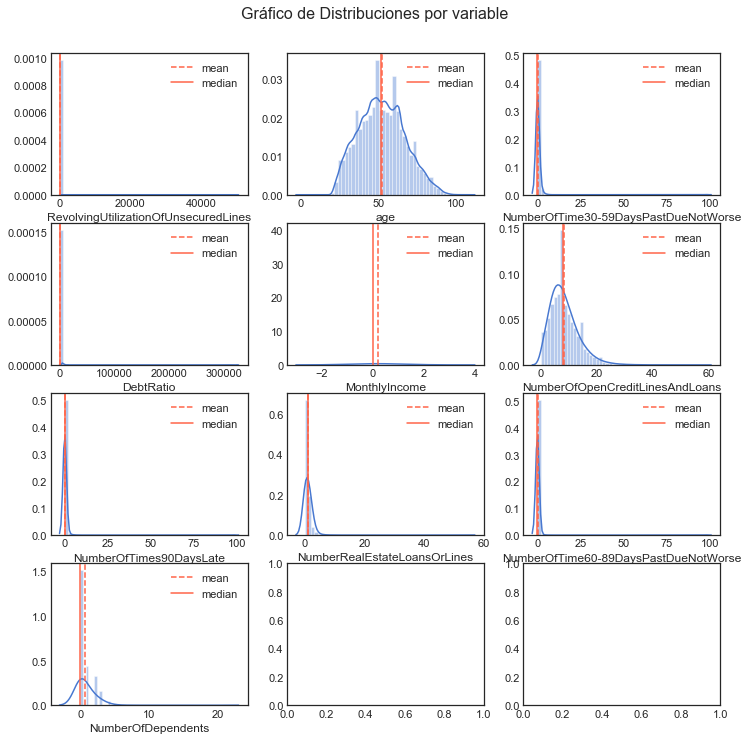

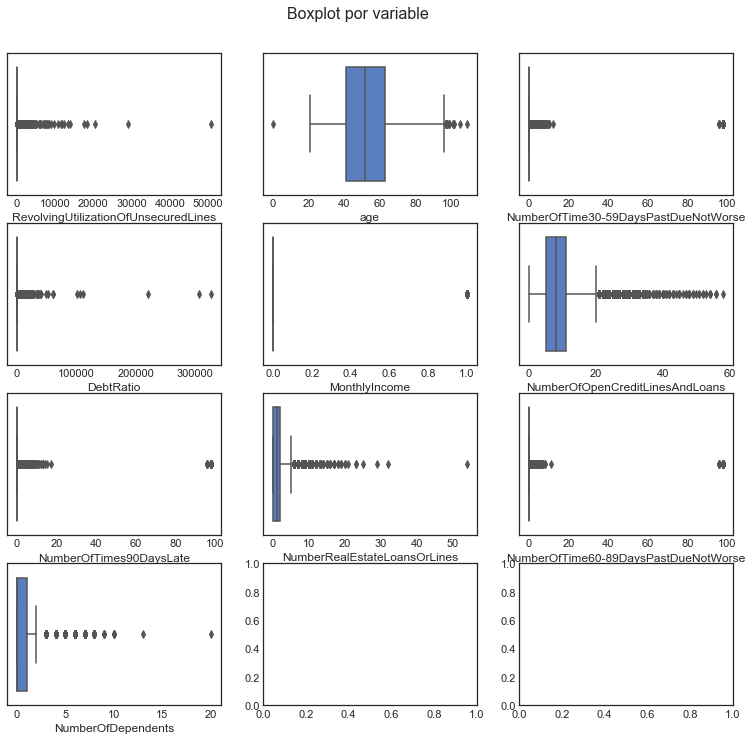

In [4]:
m = model(ruta='data_train.csv', max_na=.07)

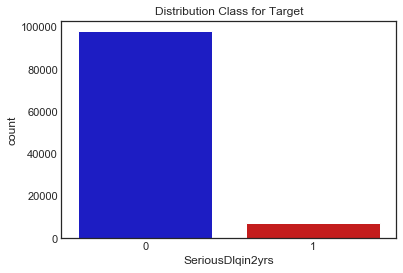

In [5]:
m.target_count()

Sub Sampling Done OK.


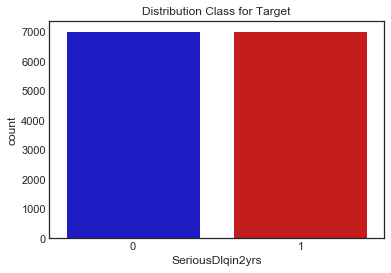

In [6]:
m.subsampling()

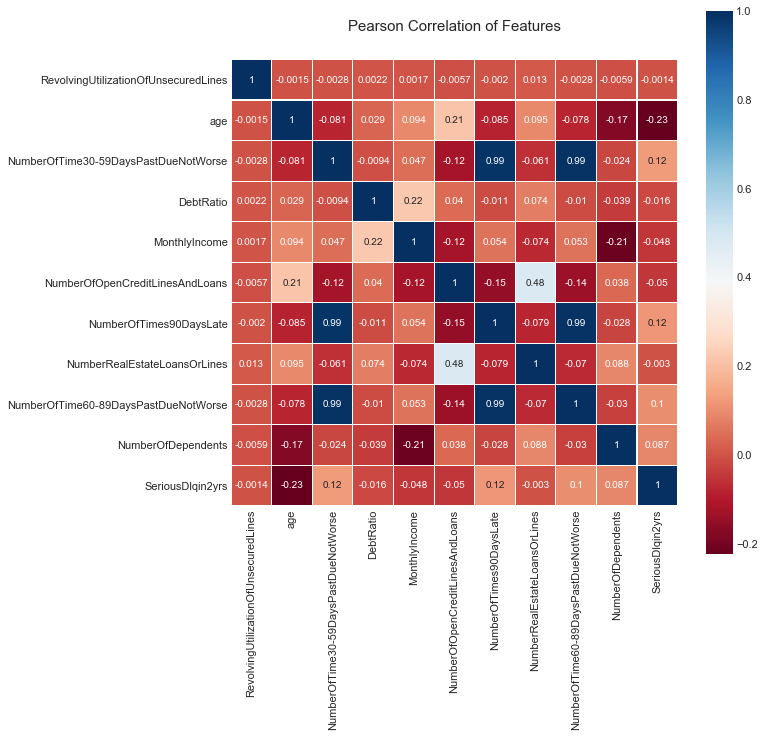

In [7]:
m.pcorr_data()

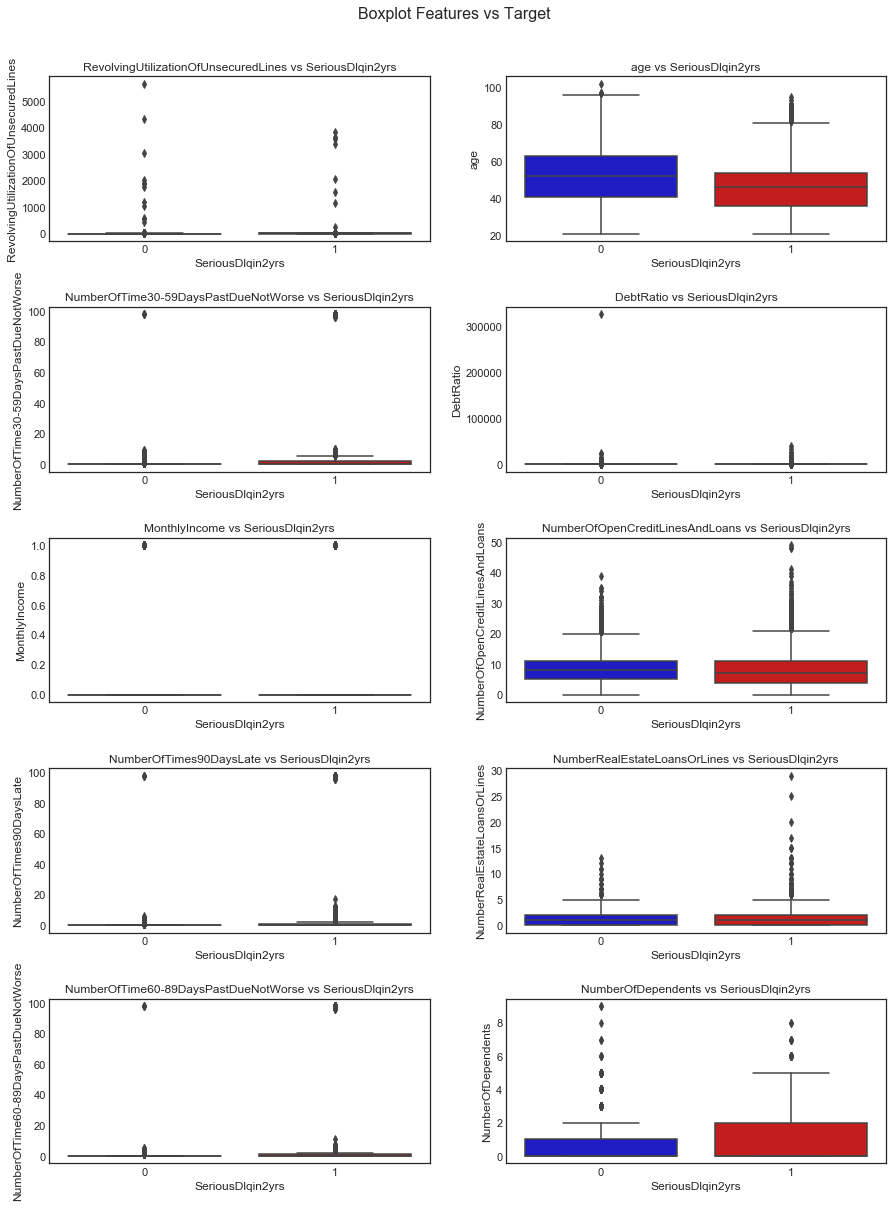

In [8]:
m.features_class()

Se suguiere transformar las siguientes variables:

__Transformación Logaritmica__
- RevolvingUtilizationOfUnsecuredLines
- DebtRatio
- NumberOfTimes90DaysLate
- MonthlyIncome

__Categorización__
- age
- NumberOfDependents
- NumberRealEstateLoansOrLines

Se evidencia la mejora del sesgo de las variables indicadas.

,count,mean,std,min,25%,50%,75%,max,skew
RevolvingUtilizationOfUnsecuredLines,14036.0,0.378110,0.392373,0.0,0.068921,0.364994,0.663831,8.639411,8.707341
age,14036.0,1.999858,1.414314,0.0,1.000000,2.000000,3.000000,4.000000,0.000101
NumberOfTime30-59DaysPastDueNotWorse,14036.0,1.315759,8.539256,0.0,0.000000,0.000000,1.000000,98.000000,11.042951
DebtRatio,14036.0,1.442424,2.526822,0.0,0.167479,0.331244,0.638610,12.696011,1.879093
MonthlyIncome,14036.0,0.126718,0.267922,0.0,0.000000,0.000000,0.000000,0.693147,1.641427
NumberOfOpenCreditLinesAndLoans,14036.0,8.183813,5.324803,0.0,4.000000,7.000000,11.000000,49.000000,1.050390
NumberOfTimes90DaysLate,14036.0,0.214928,0.565326,0.0,0.000000,0.000000,0.000000,4.595120,4.380028
NumberRealEstateLoansOrLines,14036.0,1.999858,1.414314,0.0,1.000000,2.000000,3.000000,4.000000,0.000101
NumberOfTime60-89DaysPastDueNotWorse,14036.0,0.961314,8.521220,0.0,0.000000,0.000000,0.000000,98.000000,11.234711
NumberOfDependents,14036.0,1.999858,1.414314,0.0,1.000000,2.000000,3.000000,4.000000,0.000101


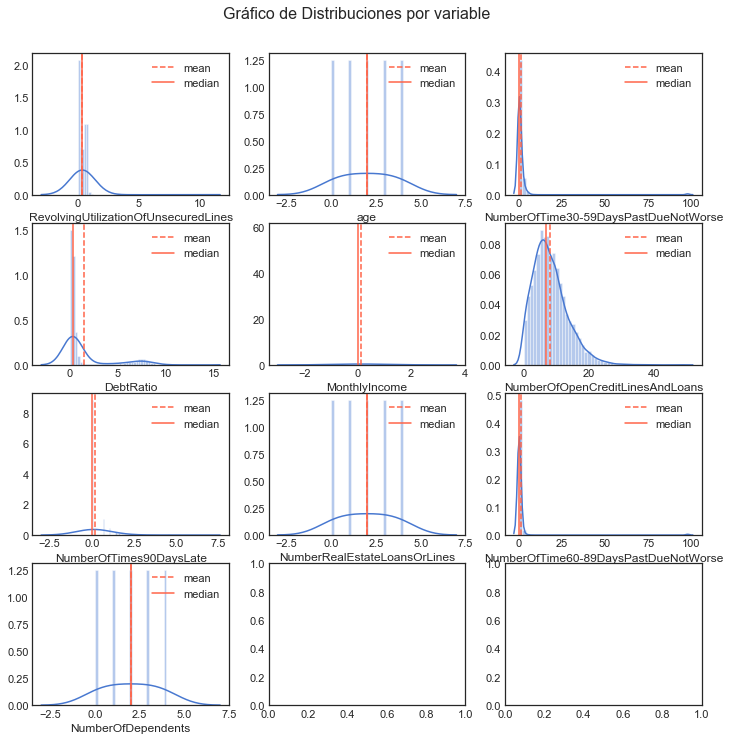

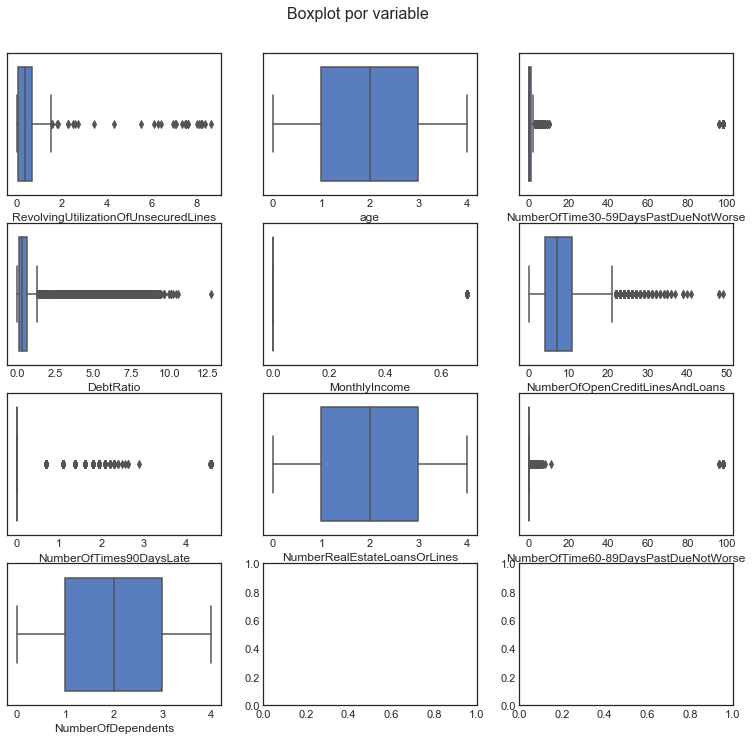

In [9]:
m.transform_data(m.X_train, 
                 log_trans = ['RevolvingUtilizationOfUnsecuredLines','DebtRatio','NumberOfTimes90DaysLate','MonthlyIncome'], 
                 cat_trans = ['age','NumberOfDependents','NumberRealEstateLoansOrLines'], 
                 max_bins = 5, 
                 density = True)

In [10]:
m.detection_outlier(m.X_train, 
                    m.y_train, 
                    cols = ['NumberOfDependents','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','age'])

,Information Value,Information Gain
RevolvingUtilizationOfUnsecuredLines,1.101469,0.097259
NumberOfTimes90DaysLate,0.480360,0.032120
NumberOfTime30-59DaysPastDueNotWorse,0.472057,0.038045
NumberOfTime60-89DaysPastDueNotWorse,0.236451,0.016504
age,0.204529,0.019600
NumberOfDependents,0.031038,0.003200
NumberOfOpenCreditLinesAndLoans,0.010836,0.001000
MonthlyIncome,0.009356,0.000000
DebtRatio,0.006271,0.000081
NumberRealEstateLoansOrLines,0.005634,0.000400


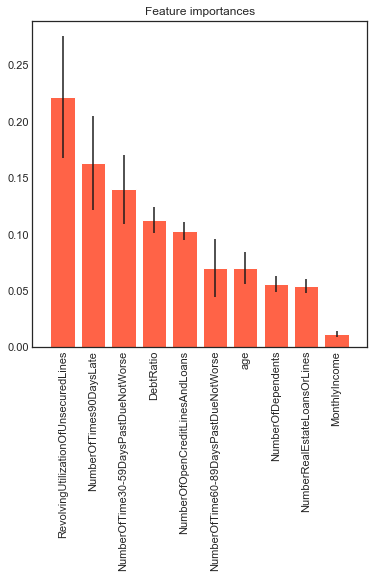

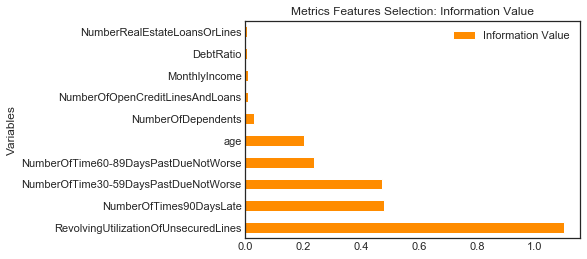

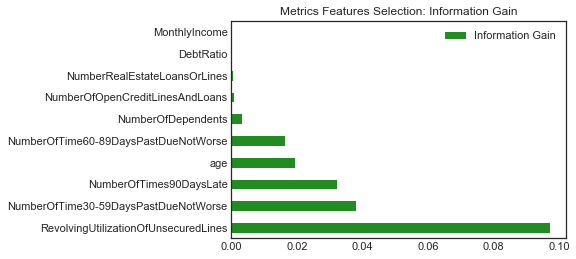

In [11]:
m.feature_importances()

De lo anterior se puede concluir:
- Las variables más relevantes para explicar la morosidad tienen relación al número de veces que se han tenido deudas en mora.
- Las variables menos relevantes parecieran ser las relacionadas a las finanza, DebRatio e MonthlyIncome.

Se sugiere descartar la variable MonthlyIncome en base a los gráficos de IG e IV. Lo mismo sugiere el gráfico de Features Importances.

In [12]:
m.model_fit(max_depth = 5)

In [13]:
m.modelo

{'LogisticRegression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=16626, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'DecisionTreeClassifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=5, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=16626, splitter='best')}

In [14]:
m.predict(ruta='data_test.csv')

Classification Report Model LogisticRegression


,0,1,accuracy,macro avg,weighted avg
precision,0.977340,0.194822,0.776511,0.586081,0.925033
recall,0.778553,0.748005,0.776511,0.763279,0.776511
f1-score,0.866694,0.309130,0.776511,0.587912,0.829424
support,41992.000000,3008.000000,0.776511,45000.000000,45000.000000


Confusion Matrix Model LogisticRegression


,Verdadero,Falso
Verdadero,32693,9299
Falso,758,2250


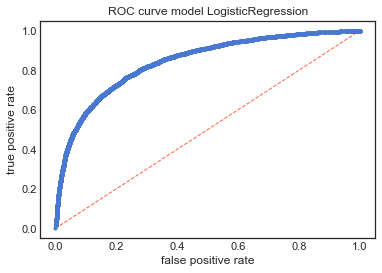

AUC Model LogisticRegression


0.8426648808549653

----

Classification Report Model DecisionTreeClassifier


,0,1,accuracy,macro avg,weighted avg
precision,0.981300,0.180427,0.742889,0.580863,0.927766
recall,0.738545,0.803524,0.742889,0.771035,0.742889
f1-score,0.842790,0.294684,0.742889,0.568737,0.806153
support,41992.000000,3008.000000,0.742889,45000.000000,45000.000000


Confusion Matrix Model DecisionTreeClassifier


,Verdadero,Falso
Verdadero,31013,10979
Falso,591,2417


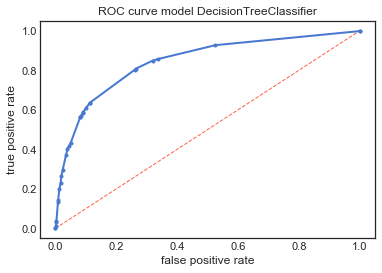

AUC Model DecisionTreeClassifier


0.8429934998383685

----

Metrics Comparation


,Model_LogisticRegression,Model_DecisionTreeClassifier
AUC,0.842665,0.842993
Accuracy,0.776510,0.742890
Presicion,0.925030,0.927770
Recall,0.776510,0.742890
F1,0.829420,0.806150


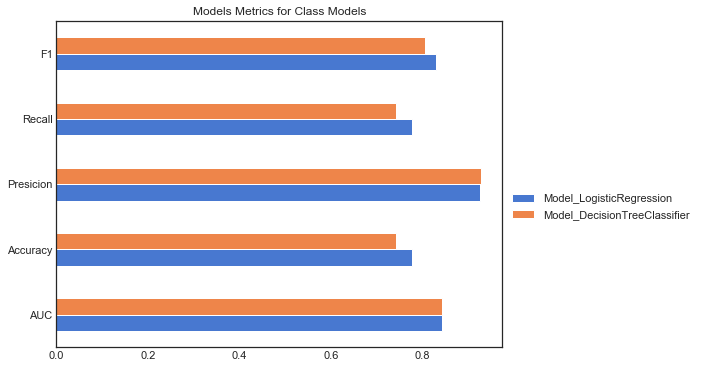

In [15]:
m.clasification_report()

In [16]:
m.save_class()

Save Class in: ./SeriousDlqin2yrs.pkl


In [17]:
m1 = pickle.load(open('./SeriousDlqin2yrs.pkl', 'rb'))

# Conclusiones
Finalmente, es pertinente concluir:
- En relación al Proceso: El objeto de clase `Model` se encuentra serializado y almacenado en el archivo `SeriousDlqin2yrs.pkl` el cual, una vez ingestado, es completamente reproducible para un nuevo set de datos con la misma estructura con la que se entreno el modelo.

- En relación a las Variables: Una de las variables más relevantes para la definición de un cliente como moroso corresponde a `RevolvingUtilizationOfUnsecuredLines`, caracteristica que hace referencia al porcentaje de credito adquirido sobre el cupo total. Posteriormente, las variables que hacen referencia al número de veces que este tuvo una mora dentro de un periodo de tiempo, ya sean 30 días, entre 30 y 50 días, etc, adquieren relevancia a la hora de definir al cliente como moroso. No menos importante es la edad.

- Con respecto a la Interpretación del Ajuste: Ambos modelos manifiestan un buen desempeño, siendo el `DecisionTreeClassifier` el modelo con un AUC levemente mayor, es decir, tiene una mejor presición o tasa de verdaderos positivos. Al comparar otras metricas, `F1` por ejemplo, el modelo `LogisticRegression` se muestra con un mejor desempeño. En definitiva, y para concluir, _"Una Logistica siempre funciona."_